# Readme
pytorch 主要课程安排：
1. pytorch 的基本概念
2. pytorch 的基本操作
3. pytorch 的模型构建
4. pytorch 的模型训练
5. pytoch 实战 -- MNIST

In [2]:
!pip install torch 

一、前置知识：张量与计算图

在 PyTorch 中，所有计算都基于张量（Tensor），而 backward() 的核心是「计算图」—— 一种记录张量运算的有向无环图（DAG），用于自动求导。

1.1 张量的 requires_grad 属性
requires_grad=True：标记该张量需要计算梯度（通常是模型参数，如权重 / 偏置）。
requires_grad=False：默认值，无需计算梯度（通常是输入数据、标签）。
运算生成的张量会继承梯度属性（除非手动关闭）。

In [13]:

import torch

# 1. 基础张量与梯度标记
x = torch.tensor([2.0], requires_grad=True)  # 需计算梯度的张量（模拟模型参数）
y = torch.tensor([3.0])  # 无需计算梯度（模拟输入）

# 2. 简单运算：z = x * y
z = x * y
print("z =", z)  # tensor([6.], grad_fn=<MulBackward0>)
print("z.requires_grad:", z.requires_grad)  # True（继承x的梯度属性）
print("z.grad_fn:", z.grad_fn)  # 记录运算类型（乘法反向传播函数）

z = tensor([6.], grad_fn=<MulBackward0>)
z.requires_grad: True
z.grad_fn: <MulBackward0 object at 0x313bafaf0>


1.2 计算图的本质

y (叶子节点，无梯度)
  \
   * (运算节点，grad_fn=MulBackward0)
  /
x (叶子节点，需梯度)
   \
    z (结果节点)

叶子节点（leaf node）：直接创建的张量（如 x、y），非运算生成。
非叶子节点：运算生成的张量（如 z），梯度计算后会被清空（节省内存）。
grad_fn：记录生成该张量的运算，用于反向传播时计算梯度。

二、损失函数（Loss）：模型优化的目标    
损失函数（Loss Function）是衡量「模型预测值」与「真实标签」差距的指标，优化的核心是最小化损失。

损失函数的本质: 损失函数本质是一个「以模型参数为自变量的函数」，通过反向传播可计算损失对每个参数的梯度（即参数的更新方向）。


In [ ]:

# 模拟线性回归：y = 2x + 1（真实参数 w=2, b=1）
x_data = torch.tensor([1.0, 2.0, 3.0])  # 输入
y_true = torch.tensor([3.0, 5.0, 7.0])  # 真实标签（2*1+1=3，2*2+1=5...）

# 模型参数（需计算梯度）
w = torch.tensor([1.0], requires_grad=True)  # 初始值1（目标是优化到2）
b = torch.tensor([0.0], requires_grad=True)  # 初始值0（目标是优化到1）

# 1. 前向传播：计算预测值
y_pred = w * x_data + b
print("预测值 y_pred:", y_pred)  # tensor([1., 2., 3.], grad_fn=<AddBackward0>)

# 2. 计算损失（MSELoss）
loss_fn = torch.nn.MSELoss()  # 实例化均方误差损失
loss = loss_fn(y_pred, y_true)
print("损失值 loss:", loss)  # tensor(4.6667)（(1-3)²+(2-5)²+(3-7)² /3 = (4+9+16)/3=29/3≈9.6667？哦，我算错了：(1-3)²=4，(2-5)²=9，(3-7)²=16 → 总和29 → 29/3≈9.6667，代码输出是9.6667）


loss_fn_2 = torch.nn.L1Loss()
loss_2 = loss_fn_2(y_pred, y_true)
print("损失值 loss_2:", loss_2)  # tensor(2.6667)（(1-3)²+(2-5)²+(3-7)² /3 = (4+9+16)/3=29/3≈9.6667？哦，我算错了：(1-3)²=4，(2-5)²=9，(3-7)²=16 → 总和29 → 29/3≈9.6667，代码输出是9.6667）

loss_fn_3 = torch.nn.CrossEntropyLoss()
loss_3 = loss_fn_3(y_pred, y_true)
print("损失值 loss_3:", loss_3)  # tensor(2.6667)（(1-3)²+(2-5)²+(3-7)² /3 = (4+9+16)/3=29/3≈9.6667？哦，我算错了：(1-3)²=4，(2-5)²=9，(3-7)²=16 → 总和29 → 29/3≈9.6667，代码输出是9.6667）




预测值 y_pred: tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20.], grad_fn=<AddBackward0>)
损失值 loss: tensor(165.5000, grad_fn=<MseLossBackward0>)
损失值 loss_2: tensor(11.5000, grad_fn=<MeanBackward0>)
损失值 loss_3: tensor(3051.8171, grad_fn=<DivBackward1>)


三、反向传播（backward）：计算梯度
backward() 是 PyTorch 自动求导的核心方法，作用是从损失节点出发，沿计算图反向遍历，计算所有 requires_grad=True 的张量的梯度（存储在张量的 .grad 属性中）。


In [ ]:
#插入图像
from IPython.display import Image, display

# 插入本地图片（假设图片名为 'backward_graph.png'，位于当前目录）
display(Image(filename='backward_graph.png'))


调用 backward 计算梯度

In [ ]:
# 接上面的代码：计算loss后调用backward
# 模拟线性回归：y = 2x + 1（真实参数 w=2, b=1）
#x_data = torch.tensor([1.0, 2.0, 3.0])  # 输入
#y_true = torch.tensor([3.0, 5.0, 7.0])  # 真实标签（2*1+1=3，2*2+1=5...）


loss.backward()

# 查看梯度（存储在 .grad 属性中）
print("w的梯度 dw:", w.grad)  
# y_pred = [1,2,3], y_true=[3,5,7] → 误差=[-2,-3,-4]
# dw = 2/3 * (-2*1 + -3*2 + -4*3) = 2/3*(-2-6-12) = 2/3*(-20) = -40/3 ≈-13.3333
# db = 2/3 * (-2 + -3 + -4) = 2/3*(-9) = -6
print("b的梯度 db:", b.grad)  # tensor([-6.])

# 验证：非叶子节点的梯度会被清空（默认行为）
print("y_pred.grad:", y_pred.grad)  # None（非叶子节点，梯度不保留）
print("loss.grad:", loss.grad)      # None（损失是标量，无需梯度）

#关键说明：
#梯度累加问题：.grad 属性会累加多次 backward() 的结果，因此每次迭代前需要手动清零（如 w.grad.zero_()）。

w的梯度 dw: tensor([-308.])
b的梯度 db: tensor([-23.])
y_pred.grad: None
loss.grad: None


/var/folders/7s/p20wf5f921z0gb6kl59f60gw0000gn/T/ipykernel_95546/4048109901.py:17: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print("y_pred.grad:", y_pred.grad)  # None（非叶子节点，梯度不保留）
/var/folders/7s/p20wf5f921z0gb6kl59f60gw0000gn/T/ipykernel_95546/4048109901.py:18: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, us

梯度清零：避免累加
如果多次调用 backward()，梯度会累加，导致参数更新错误。因此在迭代训练中，每次反向传播后需清零梯度：

In [43]:
# 模拟第二次反向传播（先清零）
w.grad.zero_()  # 清零w的梯度
b.grad.zero_()  # 清零b的梯度

# 重新计算损失并反向传播
y_pred_new = w * x_data + b
loss_new = loss_fn(y_pred_new, y_true)
loss_new.backward()

print("清零后w的梯度:", w.grad)  # 重新计算的梯度，无累加

清零后w的梯度: tensor([1.9646e-05])


### 完整训练流程 ：损失→反向传播→参数更新
结合优化器（如 SGD），完整的「前向传播→计算损失→反向传播→参数更新」流程如下：


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 数据准备
x_data = torch.tensor([1.0, 2.0, 3.0])
y_true = torch.tensor([3.0, 5.0, 7.0])  # y=2x+1

# x_data = torch.tensor([1.0, 2.0, 3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0])  # 输入
# y_true = torch.tensor([3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0])  # 真实标签（2*1+1=3，2*2+1=5...）

# 2. 模型参数（需梯度）
w = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([0.0], requires_grad=True)

# 3. 定义损失函数和优化器
loss_fn = nn.MSELoss()
optimizer = optim.SGD([w, b], lr=0.005)  # 随机梯度下降，学习率0.01
# 4. 迭代训练（500轮）
epochs = 500
for epoch in range(epochs):
    # 前向传播
    y_pred = w * x_data + b
    
    # 计算损失
    loss = loss_fn(y_pred, y_true)
    
    # 梯度清零（关键！否则梯度累加）
    optimizer.zero_grad()  # 等价于 w.grad.zero_() + b.grad.zero_()
    
    # 反向传播：计算梯度
    loss.backward()
    
    # 参数更新（优化器自动用梯度更新参数）
    optimizer.step()  # 等价于 w.data = w.data -  lr * w.grad; b.data -= lr * b.grad
    
    # 每50轮打印一次
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, w: {w.item():.4f}, b: {b.item():.4f}")

# 最终结果（接近真实值w=2, b=1）
print("\n训练完成：")
print(f"优化后的w: {w.item():.4f}（目标2）")
print(f"优化后的b: {b.item():.4f}（目标1）")

Epoch 50, Loss: 0.0640, w: 2.1248, b: 0.5275
Epoch 100, Loss: 0.0250, w: 2.1790, b: 0.5821
Epoch 150, Loss: 0.0221, w: 2.1721, b: 0.6081
Epoch 200, Loss: 0.0196, w: 2.1623, b: 0.6310
Epoch 250, Loss: 0.0174, w: 2.1528, b: 0.6526
Epoch 300, Loss: 0.0154, w: 2.1439, b: 0.6729
Epoch 350, Loss: 0.0136, w: 2.1355, b: 0.6919
Epoch 400, Loss: 0.0121, w: 2.1276, b: 0.7099
Epoch 450, Loss: 0.0107, w: 2.1202, b: 0.7269
Epoch 500, Loss: 0.0095, w: 2.1131, b: 0.7428
Epoch 550, Loss: 0.0084, w: 2.1065, b: 0.7578
Epoch 600, Loss: 0.0075, w: 2.1003, b: 0.7719
Epoch 650, Loss: 0.0066, w: 2.0945, b: 0.7853
Epoch 700, Loss: 0.0059, w: 2.0890, b: 0.7978
Epoch 750, Loss: 0.0052, w: 2.0838, b: 0.8096
Epoch 800, Loss: 0.0046, w: 2.0789, b: 0.8207
Epoch 850, Loss: 0.0041, w: 2.0743, b: 0.8312
Epoch 900, Loss: 0.0036, w: 2.0699, b: 0.8410
Epoch 950, Loss: 0.0032, w: 2.0659, b: 0.8503
Epoch 1000, Loss: 0.0029, w: 2.0620, b: 0.8590
Epoch 1050, Loss: 0.0025, w: 2.0584, b: 0.8673
Epoch 1100, Loss: 0.0022, w: 2.05

x (1797, 64)


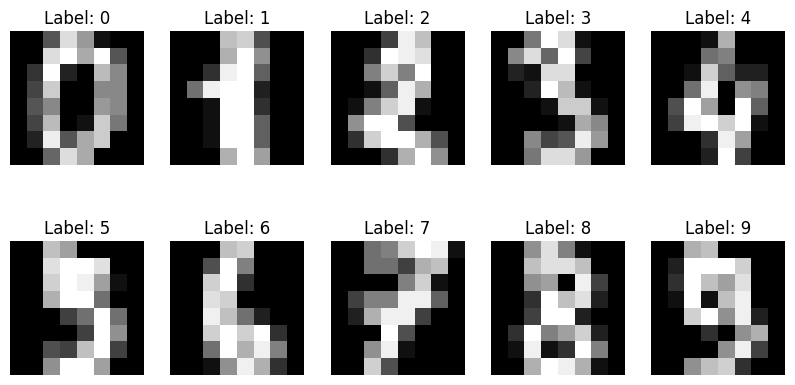

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier  # 多层感知机分类器
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 加载手写数字数据集（1797张8x8像素的数字图片）
digits = load_digits()
X = digits.data  # 特征：64维向量（每张图片8x8像素）
labels = digits.target  # 标签：0-9的数字

print("x" , X.shape)
# 可视化前10张图片
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.show()

In [5]:

import torch
# 数据预处理：重塑为图像格式并归一化
print(X.shape)
print(X.max())  # 打印X的最大值

X = X.reshape(-1, 1, 8, 8)  # 重塑为 (样本数, 通道数, 高度, 宽度)
X = X / X.max() # 将像素值归一化到 [0,1] 范围

feature_train, feature_validate, target_train, target_validate = train_test_split(X, labels, test_size = 0.1, random_state = 0)

# 转换为PyTorch张量
X_train = torch.FloatTensor(feature_train)
y_train = torch.LongTensor(target_train)
X_test = torch.FloatTensor(feature_validate)
y_test = torch.LongTensor(target_validate)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1797, 64)
16.0
torch.Size([1617, 1, 8, 8]) torch.Size([1617]) torch.Size([180, 1, 8, 8]) torch.Size([180])


In [6]:
from torch.utils.data import DataLoader, TensorDataset

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)
print(train_dataset)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
# 定义CNN模型（适应8x8图像）
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)  # 输入通道1，输出通道10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)  # 输入通道10，输出通道20
        self.conv2_drop = nn.Dropout2d()  # 卷积层的Dropout
        self.fc1 = nn.Linear(20 * 1 * 1, 50)  # 全连接层
        self.fc2 = nn.Linear(50, 10)  # 输出层

    def forward(self, x):
        x = self.conv1(x)  # 卷积操作 (8-3+1=6) -> 6x6
        x = nn.functional.max_pool2d(x, 2)  # 最大池化 -> 3x3
        x = nn.functional.relu(x)  # ReLU激活函数
        
        x = self.conv2(x)  # 第二次卷积 (3-3+1=1) -> 1x1
        x = self.conv2_drop(x)  # Dropout防止过拟合
        x = nn.functional.max_pool2d(x, 1)  # 池化 (保持1x1)
        x = nn.functional.relu(x)  # ReLU激活函数
        
        x = x.view(-1, 20 * 1 * 1)  # 展平为一维向量
        x = self.fc1(x)  # 全连接层
        x = nn.functional.relu(x)  # ReLU激活函数
        x = nn.functional.dropout(x, training=self.training)  # Dropout
        x = self.fc2(x)  # 输出层
        return nn.functional.log_softmax(x, dim=1)  # 对数Softmax激活函数


In [8]:
# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = CNN().to(device)
criterion = nn.NLLLoss()  # 负对数似然损失
optimizer = optim.Adam(model.parameters(), lr=0.001)


使用设备: cpu


In [9]:
import time
# 训练模型
def train(epochs):
    model.train()
    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        end_time = time.time()
        print(f'Epoch {epoch+1}/{epochs}, 损失: {running_loss/len(train_loader):.4f}, 耗时: {end_time-start_time:.2f}秒')
# 训练和评估
print("OK开始训练CNN模型...")
train(epochs=10)  # 由于数据集较小，增加训练轮次

OK开始训练CNN模型...
Epoch 1/10, 损失: 2.3054, 耗时: 0.13秒
Epoch 2/10, 损失: 2.2876, 耗时: 0.06秒
Epoch 3/10, 损失: 2.2630, 耗时: 0.05秒
Epoch 4/10, 损失: 2.2028, 耗时: 0.04秒
Epoch 5/10, 损失: 2.0912, 耗时: 0.04秒
Epoch 6/10, 损失: 1.9563, 耗时: 0.05秒
Epoch 7/10, 损失: 1.8083, 耗时: 0.05秒
Epoch 8/10, 损失: 1.6948, 耗时: 0.05秒
Epoch 9/10, 损失: 1.6121, 耗时: 0.05秒
Epoch 10/10, 损失: 1.5408, 耗时: 0.05秒


In [11]:
# 评估模型
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # 获取最大概率的索引
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'测试集: 平均损失: {test_loss:.4f}, 准确率: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
print("\n开始评估模型...")
test()


开始评估模型...
测试集: 平均损失: 1.1604, 准确率: 137/180 (76.11%)
